In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy import stats, integrate
from time import time
import ROOT

Welcome to JupyROOT 6.28/04


In [2]:
# default parameters (for pi+ in liquid argon)
mass = 139.57039 # MeV
charge = 1
rho = 1.39 # g/cm3
K = 0.307075 # MeV cm2 / mol
Z = 18
A = 39.948 # g / mol
I = 188.0e-6 # MeV, mean excitation energy
me = 0.511 # MeV
def Landau_xi(KE, pitch, beta2):
    xi = rho * pitch * 0.5 * K * (Z / A) / beta2
    return xi
def Get_Wmax(KE):
    gamma = (KE/mass)+1.0
    beta2 = 1-(1.0/(gamma*gamma))
    Wmax = (2.0 * me * beta2 * gamma*gamma) / (1.0 + 2.0 * me * (gamma / mass) + (me / mass)*(me / mass))
    return Wmax
def densityEffect(beta, gamma):
    density_y = np.log10(beta * gamma)
    ln10 = np.log(10)
    if density_y > 3.0:
        this_delta = 2.0 * ln10 * density_y - 5.2146
    elif density_y < 0.2:
        this_delta = 0
    else:
        this_delta = 2.0 * ln10 * density_y - 5.2146 + 0.19559 * np.power(3.0 - density_y, 3)
    return this_delta
    
def dEdx_mean(KE): # Bethe-Bloch
    gamma = (KE/mass)+1.0
    beta = np.sqrt(1-(1.0/(gamma*gamma)))
    Wmax = Get_Wmax(KE)
    dEdx = (rho*K*Z*charge*charge)/(A*beta*beta)*(0.5*np.log(2*me*gamma*gamma*beta*beta*Wmax/I/I) - beta*beta - densityEffect(beta, gamma)/2 )
    return dEdx

def dEdx_MPV(KE, pitch):
    gamma = (KE/mass)+1.0
    beta = np.sqrt(1-(1.0/(gamma*gamma)))
    delta = densityEffect(beta, gamma)
    xi = Landau_xi(KE, pitch, beta*beta)
    a0 = 2*me * (beta*gamma)*(beta*gamma) / I
    mpv = (xi/pitch) * (np.log(a0) + np.log(xi/I) + 0.2 - beta*beta - delta)
    return mpv

def dEdx_pdf(dEdx, KE, pitch): # Landau-Vavilov
    gamma = (KE/mass)+1.0
    beta2 = 1-(1.0/(gamma*gamma))
    this_xi = Landau_xi(KE, pitch, beta2)
    this_Wmax = Get_Wmax(KE)
    this_kappa = this_xi / this_Wmax
    this_meandEdx = dEdx_mean(KE)
    
    par1 = this_xi/pitch
    par2 = (0.422784 + beta2 + np.log(this_kappa)) * this_xi / pitch + this_meandEdx
    par3 = (dEdx - par2) / par1

    vav = ROOT.Math.VavilovAccurate()
    if this_kappa < 0.01: # Landau
        this_pdf = ROOT.Math.landau_pdf(par3) / par1
    elif this_kappa > 10: # Gaussian
        mu = vav.Mean(this_kappa, beta2)
        sigma = np.sqrt(vav.Variance(this_kappa, beta2))
        this_pdf = ROOT.Math.gaussian_pdf(par3, sigma, mu) / par1
    else: # Vavilov
        this_pdf = vav.Pdf(par3, this_kappa, beta2) / par1
    return this_pdf
def dEdx_cutoff(KE, pitch): # for Landau distribution
    gamma = (KE/mass)+1.0
    beta2 = 1-(1.0/(gamma*gamma))
    Wmax = Get_Wmax(KE)
    xi = Landau_xi(KE, pitch, beta2)
    kappa = xi / Wmax
    if kappa > 10: # Gaussian
        return 2*dEdx_mean(KE)
    elif kappa > 0.01: # Vavilov
        return 100
    else: # Landau
        lambda_bar = (np.euler_gamma-1) - beta2 - np.log(kappa)
        lambda_max = 0.51146 + 1.19486 * lambda_bar + (0.465814 + 0.0115374 * lambda_bar) * np.exp(1.17165 + 0.979242 * lambda_bar)
        cutoff = (lambda_max + 1-np.euler_gamma + beta2 + np.log(kappa)) * (xi / pitch) + dEdx_mean(KE)
        return cutoff


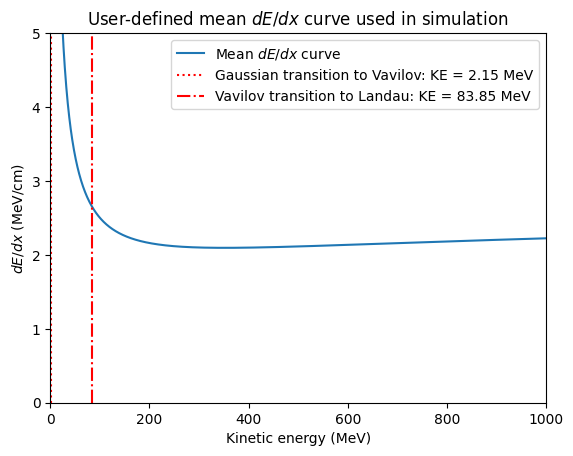

In [3]:
### Bethe-Bloch function
BBxxm = 2000 # max KE to use the mean dE/dx function
BBxx = np.arange(0, BBxxm+0.5, 0.5)
BByy0 = 200 # Mean dE/dx value at KE = 0 (in priciple, it is infinity)
BByy = np.concatenate([[BByy0], [dEdx_mean(ixx) for ixx in BBxx[1:]]])

### plot the simulated dE/dx curve
plt.plot(BBxx, BByy, "-", label=r"Mean $dE/dx$ curve")
plt.xlim([0,1000])
ylim = [0,5]
plt.ylim(ylim)
plt.xlabel("Kinetic energy (MeV)")
plt.ylabel(r"$dE/dx$ (MeV/cm)")
plt.title(r"User-defined mean $dE/dx$ curve used in simulation")
KE_gaus2vav = 2.15 # kappa is 10.140097002663536 given pitch==0.1
KE_vav2land = 83.85 # kappa is 0.00999211641570322 given pitch==0.1
plt.plot([KE_gaus2vav]*2, ylim, "r:", label=f"Gaussian transition to Vavilov: KE = {KE_gaus2vav} MeV")
plt.plot([KE_vav2land]*2, ylim, "r-.", label=f"Vavilov transition to Landau: KE = {KE_vav2land} MeV")
plt.legend()
plt.show()

### save the mean dE/dx curve to txt
file_dEdx_mean = "inputs/dEdx_mean.txt"
np.savetxt(file_dEdx_mean, [BBxx, BByy])

### Landau
Cut-off used:  56.716832676890164 MeV
Integral:  0.9981131423635798
MPV:  1.4724495354498996 MeV
Mean from integration:	 2.098112230435266 MeV
Mean from dEdx_mean:	 2.098110890376507 MeV


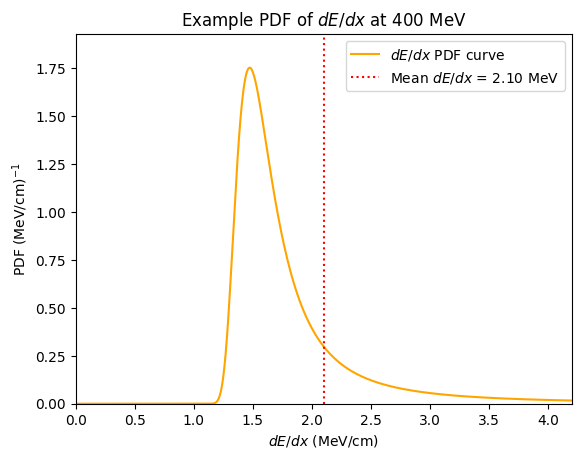

### Vavilov
Cut-off used:  100 MeV
Integral:  1.0000000071949195
Mean from integration:	 5.8783893853451135 MeV
Mean from dEdx_mean:	 5.8780424594591 MeV


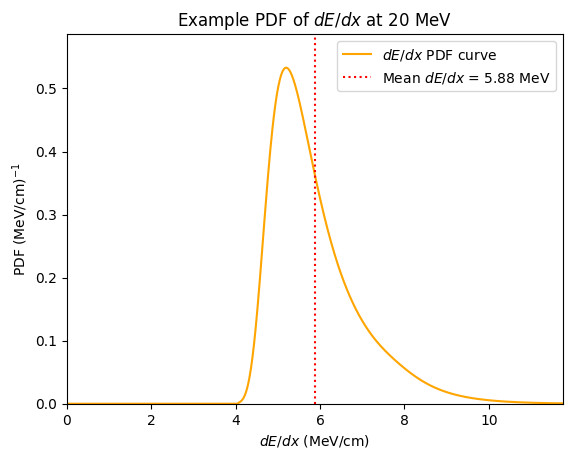

### Gaussian
Cut-off used:  68.88133999326551 MeV
Integral:  1.0000000000000007
Mean from integration:	 34.44066884802913 MeV
Mean from dEdx_mean:	 34.44066999663276 MeV


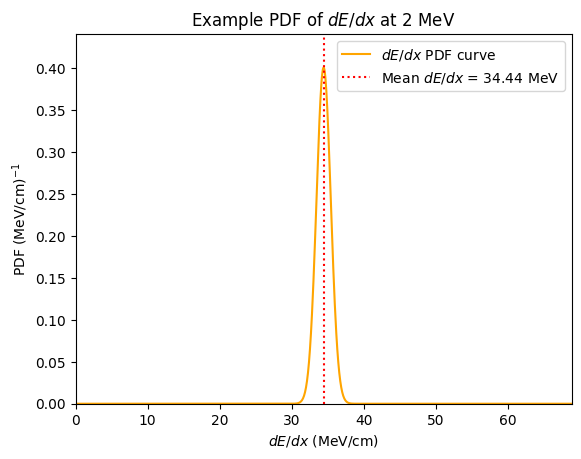

In [4]:
### dE/dx distribution
test_pitch = 0.1
print("### Landau")
test_KE_1 = 400 # [83.9, inf] given test_pitch==0.1
dEdx_pdf_arr_1 = []
xx_1 = np.linspace(0,2*dEdx_mean(test_KE_1),1000)
for ixx in xx_1:
    dEdx_pdf_arr_1.append(dEdx_pdf(ixx, test_KE_1, test_pitch))
plt.plot(xx_1, dEdx_pdf_arr_1, "orange", label=r"$dE/dx$ PDF curve")
cutoff = dEdx_cutoff(test_KE_1, test_pitch)
integral = integrate.quad(lambda x: dEdx_pdf(x, test_KE_1, test_pitch), 0, cutoff)
print("Cut-off used: ", cutoff, "MeV")
print("Integral: ", integral[0])
print("MPV: ", dEdx_MPV(test_KE_1, test_pitch), "MeV")
print("Mean from integration:\t", integrate.quad(lambda x: x*dEdx_pdf(x, test_KE_1, test_pitch)/integral[0], 0, cutoff)[0], "MeV")
print("Mean from dEdx_mean:\t", dEdx_mean(test_KE_1), "MeV")
ylim = [0,1.1*np.max(dEdx_pdf_arr_1)]
plt.plot([dEdx_mean(test_KE_1)]*2, ylim, "r:", label=rf"Mean $dE/dx$ = {dEdx_mean(test_KE_1):.2f} MeV")
plt.xlim([0,2*dEdx_mean(test_KE_1)])
plt.ylim(ylim)
plt.xlabel(r"$dE/dx$ (MeV/cm)")
plt.ylabel(r"PDF (MeV/cm)$^{-1}$")
plt.title(rf"Example PDF of $dE/dx$ at {test_KE_1} MeV")
plt.legend()
plt.show()

print("### Vavilov")
test_KE_2 = 20 # [2.2, 83.8] given test_pitch==0.1
dEdx_pdf_arr_2 = []
xx_2 = np.linspace(0,2*dEdx_mean(test_KE_2),1000)
for ixx in xx_2:
    dEdx_pdf_arr_2.append(dEdx_pdf(ixx, test_KE_2, test_pitch))
plt.plot(xx_2, dEdx_pdf_arr_2, "orange", label=r"$dE/dx$ PDF curve")
cutoff = dEdx_cutoff(test_KE_2, test_pitch)
integral = integrate.quad(lambda x: dEdx_pdf(x, test_KE_2, test_pitch), 0, cutoff)
print("Cut-off used: ", cutoff, "MeV")
print("Integral: ", integral[0])
#print("MPV: ", dEdx_MPV(test_KE_2, test_pitch), "MeV")
print("Mean from integration:\t", integrate.quad(lambda x: x*dEdx_pdf(x, test_KE_2, test_pitch)/integral[0], 0, cutoff)[0], "MeV")
print("Mean from dEdx_mean:\t", dEdx_mean(test_KE_2), "MeV")
ylim = [0,1.1*np.max(dEdx_pdf_arr_2)]
plt.plot([dEdx_mean(test_KE_2)]*2, ylim, "r:", label=rf"Mean $dE/dx$ = {dEdx_mean(test_KE_2):.2f} MeV")
plt.xlim([0,2*dEdx_mean(test_KE_2)])
plt.ylim(ylim)
plt.xlabel(r"$dE/dx$ (MeV/cm)")
plt.ylabel(r"PDF (MeV/cm)$^{-1}$")
plt.title(rf"Example PDF of $dE/dx$ at {test_KE_2} MeV")
plt.legend()
plt.show()

print("### Gaussian")
test_KE_3 = 2 # [0, 2.1] given test_pitch==0.1
dEdx_pdf_arr_3 = []
xx_3 = np.linspace(0,2*dEdx_mean(test_KE_3),1000)
for ixx in xx_3:
    dEdx_pdf_arr_3.append(dEdx_pdf(ixx, test_KE_3, test_pitch))
plt.plot(xx_3, dEdx_pdf_arr_3, "orange", label=r"$dE/dx$ PDF curve")
cutoff = dEdx_cutoff(test_KE_3, test_pitch)
integral = integrate.quad(lambda x: dEdx_pdf(x, test_KE_3, test_pitch), 0, cutoff)
print("Cut-off used: ", cutoff, "MeV")
print("Integral: ", integral[0])
#print("MPV: ", dEdx_MPV(test_KE_3, test_pitch), "MeV") # dEdx_MPV assumes thin-target, while in the Gaussian case it does not apply
print("Mean from integration:\t", integrate.quad(lambda x: x*dEdx_pdf(x, test_KE_3, test_pitch)/integral[0], 0, cutoff)[0], "MeV")
print("Mean from dEdx_mean:\t", dEdx_mean(test_KE_3), "MeV")
ylim = [0,1.1*np.max(dEdx_pdf_arr_3)]
plt.plot([dEdx_mean(test_KE_3)]*2, ylim, "r:", label=rf"Mean $dE/dx$ = {dEdx_mean(test_KE_3):.2f} MeV")
plt.xlim([0,2*dEdx_mean(test_KE_3)])
plt.ylim(ylim)
plt.xlabel(r"$dE/dx$ (MeV/cm)")
plt.ylabel(r"PDF (MeV/cm)$^{-1}$")
plt.title(rf"Example PDF of $dE/dx$ at {test_KE_3} MeV")
plt.legend()
plt.show()

### save the dE/dx PDF curve in the Landau case to txt
file_dEdx_pdf = "inputs/dEdx_pdf.txt"
xx = np.linspace(0, 5, 1000)
dEdx_pdf_arr = [dEdx_pdf(ixx, test_KE_1, test_pitch) for ixx in xx]
np.savetxt(file_dEdx_pdf, [xx, dEdx_pdf_arr])

In [5]:
### generate random number from dE/dx PPF
def dEdx_cdf(dEdx, KE, pitch):
    gamma = (KE/mass)+1.0
    beta2 = 1-(1.0/(gamma*gamma))
    this_xi = Landau_xi(KE, pitch, beta2)
    this_Wmax = Get_Wmax(KE)
    this_kappa = this_xi / this_Wmax
    this_meandEdx = dEdx_mean(KE)
    
    par1 = this_xi/pitch
    par2 = (0.422784 + beta2 + np.log(this_kappa)) * this_xi / pitch + this_meandEdx
    par3 = (dEdx - par2) / par1

    vav = ROOT.Math.VavilovAccurate()
    if this_kappa < 0.01: # Landau
        this_cdf = ROOT.Math.landau_cdf(par3)
    elif this_kappa > 10: # Gaussian
        mu = vav.Mean(this_kappa, beta2)
        sigma = np.sqrt(vav.Variance(this_kappa, beta2))
        this_cdf = ROOT.Math.gaussian_cdf(par3, sigma, mu)
    else: # Vavilov
        this_cdf = vav.Cdf(par3, this_kappa, beta2)
    return this_cdf
def dEdx_ppf(pv, KE, pitch):
    gamma = (KE/mass)+1.0
    beta2 = 1-(1.0/(gamma*gamma))
    this_xi = Landau_xi(KE, pitch, beta2)
    this_Wmax = Get_Wmax(KE)
    this_kappa = this_xi / this_Wmax
    this_meandEdx = dEdx_mean(KE)
    
    par1 = this_xi/pitch
    par2 = (0.422784 + beta2 + np.log(this_kappa)) * this_xi / pitch + this_meandEdx

    vav = ROOT.Math.VavilovAccurate()
    if this_kappa < 0.01: # Landau
        pvmax = dEdx_cdf(dEdx_cutoff(KE, pitch), KE, pitch) # PDF integral up to cutoff
        this_ppf = ROOT.Math.landau_quantile(pv*pvmax)
    elif this_kappa > 10: # Gaussian
        mu = vav.Mean(this_kappa, beta2)
        sigma = np.sqrt(vav.Variance(this_kappa, beta2))
        this_ppf = ROOT.Math.gaussian_quantile(pv, sigma) + mu
    else: # Vavilov
        this_ppf = vav.Quantile(pv, this_kappa, beta2)
    this_ppf = this_ppf * par1 + par2
    return this_ppf

def dEdx_ppf_rdm(KE, pitch=0.1, size=1): # generate random number from dE/dx PPF
    if size == 1:
        pv = np.random.rand() # a random number uniformly distributed in [0, 1]
        this_dEdx = dEdx_ppf(pv, KE, pitch)
    else:
        pv = np.random.rand(size) # a random number uniformly distributed in [0, 1]
        this_dEdx = np.array([dEdx_ppf(ipv, KE, pitch) for ipv in pv])
    return this_dEdx

We are going to shift the distribution (with the same shape) in the corresponding ranges for the three cases.

### Landau


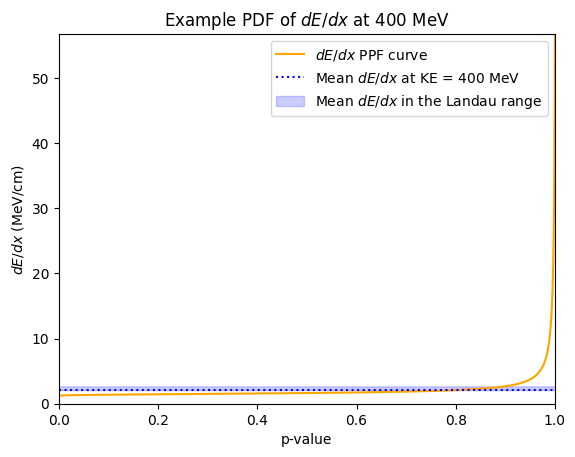

### Vavilov


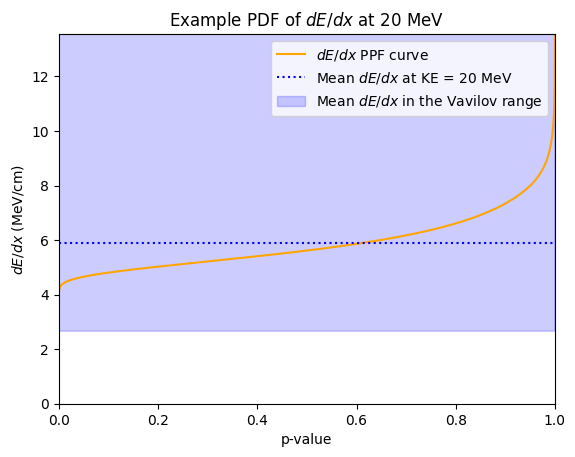

### Gaussian


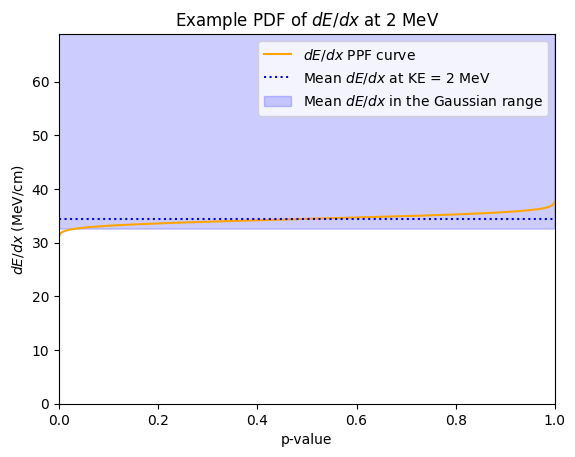

In [6]:
print("### Landau")
test_KE = test_KE_1
dEdx_ppf_arr_1 = []
pvxx = np.linspace(0,1,2000)
for ixx in pvxx[1:]:
    dEdx_ppf_arr_1.append(dEdx_ppf(ixx, test_KE, test_pitch))
dEdx_ppf_arr_1.insert(0, dEdx_ppf_arr_1[0])
plt.plot(pvxx, dEdx_ppf_arr_1, "orange", label=r"$dE/dx$ PPF curve")
ylim = [0, dEdx_cutoff(test_KE, test_pitch)]
plt.xlim([0, 1])
plt.ylim(ylim)
plt.xlabel(r"p-value")
plt.ylabel(r"$dE/dx$ (MeV/cm)")
plt.title(rf"Example PDF of $dE/dx$ at {test_KE} MeV")
plt.axhline(y=dEdx_mean(test_KE_1), color='b', linestyle=':', label=rf'Mean $dE/dx$ at KE = {test_KE_1} MeV')
plt.fill_between(pvxx, np.min(BByy), dEdx_mean(KE_vav2land), color='b', alpha=0.2, label=r'Mean $dE/dx$ in the Landau range')
plt.legend()
plt.show()

print("### Vavilov")
test_KE = test_KE_2
dEdx_ppf_arr_2 = []
for ixx in pvxx:
    dEdx_ppf_arr_2.append(dEdx_ppf(ixx, test_KE, test_pitch))
plt.plot(pvxx, dEdx_ppf_arr_2, "orange", label=r"$dE/dx$ PPF curve")
ylim = [0, dEdx_ppf_arr_2[-1]]
plt.xlim([0, 1])
plt.ylim(ylim)
plt.xlabel(r"p-value")
plt.ylabel(r"$dE/dx$ (MeV/cm)")
plt.title(rf"Example PDF of $dE/dx$ at {test_KE} MeV")
plt.axhline(y=dEdx_mean(test_KE_2), color='b', linestyle=':', label=rf'Mean $dE/dx$ at KE = {test_KE_2} MeV')
plt.fill_between(pvxx, dEdx_mean(KE_vav2land), dEdx_mean(KE_gaus2vav), color='b', alpha=0.2, label=r'Mean $dE/dx$ in the Vavilov range')
plt.legend()
plt.show()

print("### Gaussian")
test_KE = test_KE_3
dEdx_ppf_arr_3 = []
for ixx in pvxx[1:-1]:
    dEdx_ppf_arr_3.append(dEdx_ppf(ixx, test_KE, test_pitch))
dEdx_ppf_arr_3.insert(0, dEdx_ppf_arr_3[0])
dEdx_ppf_arr_3.append(dEdx_ppf_arr_3[-1])
plt.plot(pvxx, dEdx_ppf_arr_3, "orange", label=r"$dE/dx$ PPF curve")
ylim = [0, dEdx_cutoff(test_KE, test_pitch)]
plt.xlim([0, 1])
plt.ylim(ylim)
plt.xlabel(r"p-value")
plt.ylabel(r"$dE/dx$ (MeV/cm)")
plt.title(rf"Example PDF of $dE/dx$ at {test_KE} MeV")
plt.axhline(y=dEdx_mean(test_KE_3), color='b', linestyle=':', label=rf'Mean $dE/dx$ at KE = {test_KE_3} MeV')
plt.fill_between(pvxx, dEdx_mean(KE_gaus2vav), np.max(BByy), color='b', alpha=0.2, label=r'Mean $dE/dx$ in the Gaussian range')
plt.legend()
plt.show()

### save the dE/dx PPF curves in three cases to txt
file_dEdx_ppf = "inputs/dEdx_ppf.txt"
np.savetxt(file_dEdx_ppf, [pvxx, dEdx_ppf_arr_1, dEdx_ppf_arr_2, dEdx_ppf_arr_3])

In [7]:
dEdx_ppf_landau = lambda KE: np.interp(KE, pvxx, dEdx_ppf_arr_1)
dEdx_ppf_vavilov = lambda KE: np.interp(KE, pvxx, dEdx_ppf_arr_2)
dEdx_ppf_gaussian = lambda KE: np.interp(KE, pvxx, dEdx_ppf_arr_3)
def dEdx_rdm(KE, size=1):
    pv = np.random.rand(size) # a random number uniformly distributed in [0, 1]
    if KE > KE_vav2land:
        return dEdx_ppf_landau(pv) + dEdx_mean(KE)-dEdx_mean(test_KE_1)
    if KE > KE_gaus2vav:
        return dEdx_ppf_vavilov(pv) + dEdx_mean(KE)-dEdx_mean(test_KE_2)
    else:
        return dEdx_ppf_gaussian(pv) + dEdx_mean(KE)-dEdx_mean(test_KE_3)

### Landau
Mean from integration:			2.098112230435266 MeV
Mean from dEdx_mean:			2.098110890376507 MeV
Mean of generated raondom numbers:	2.098414452891018 ± 0.0007517424995540435 MeV


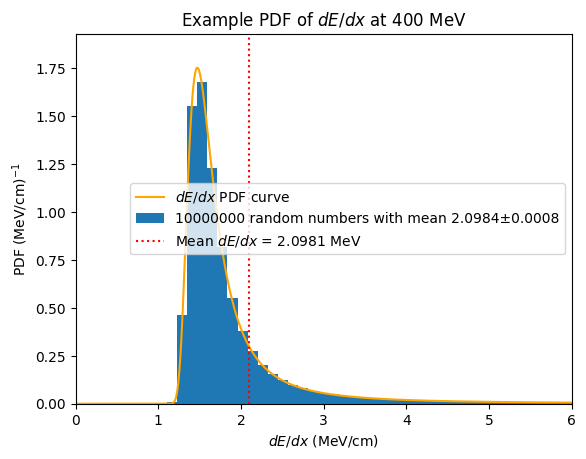

### Vavilov
Mean from integration:			5.8783893853451135 MeV
Mean from dEdx_mean:			5.8780424594591 MeV
Mean of generated raondom numbers:	5.878415138390179 ± 0.0003356670522973226 MeV


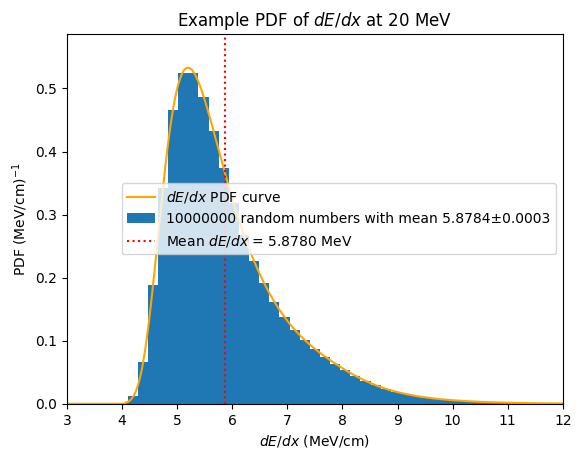

### Gaussian
Mean from integration:			34.44066884802913 MeV
Mean from dEdx_mean:			34.44066999663276 MeV
Mean of generated raondom numbers:	34.44108982044649 ± 0.00031426707751868073 MeV


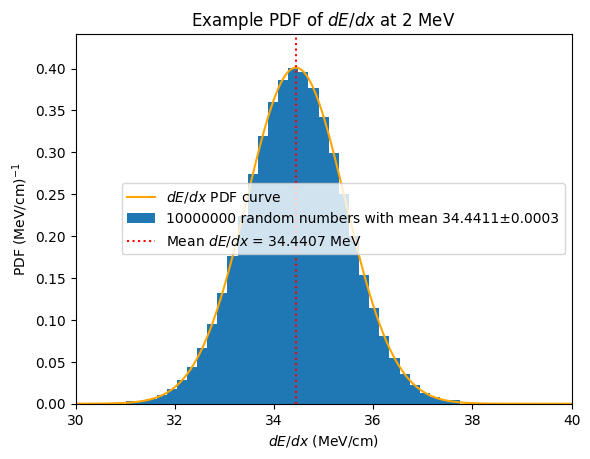

In [8]:
### dE/dx distribution
Nrdm = 10000000
dEdx_rdm_interp_1 = dEdx_rdm(test_KE_1, Nrdm)
dEdx_rdm_interp_2 = dEdx_rdm(test_KE_2, Nrdm)
dEdx_rdm_interp_3 = dEdx_rdm(test_KE_3, Nrdm)

print("### Landau")
test_KE = test_KE_1
dEdx_rdm_arr = dEdx_rdm_interp_1
xrange = [0, 6]
dEdx_pdf_arr = []
xx = np.linspace(*xrange,1000)
for ixx in xx:
    dEdx_pdf_arr.append(dEdx_pdf(ixx, test_KE, test_pitch))
plt.plot(xx, dEdx_pdf_arr, "orange", label=r"$dE/dx$ PDF curve")
cutoff = dEdx_cutoff(test_KE, test_pitch)
integral = integrate.quad(lambda x: dEdx_pdf(x, test_KE, test_pitch), 0, cutoff)
print(f"Mean from integration:\t\t\t{integrate.quad(lambda x: x*dEdx_pdf(x, test_KE, test_pitch)/integral[0], 0, cutoff)[0]} MeV")
print(f"Mean from dEdx_mean:\t\t\t{dEdx_mean(test_KE)} MeV")
ylim = [0,1.1*np.max(dEdx_pdf_arr)]
print(f"Mean of generated raondom numbers:\t{np.mean(dEdx_rdm_arr)} ± {stats.sem(dEdx_rdm_arr)} MeV")
plt.hist(dEdx_rdm_arr, bins=np.linspace(*xrange,50), density=True, label=f"{Nrdm} random numbers with mean {np.mean(dEdx_rdm_arr):.4f}±{stats.sem(dEdx_rdm_arr):.4f}")
plt.plot([dEdx_mean(test_KE)]*2, ylim, "r:", label=rf"Mean $dE/dx$ = {dEdx_mean(test_KE):.4f} MeV")
plt.xlim(xrange)
plt.ylim(ylim)
plt.xlabel(r"$dE/dx$ (MeV/cm)")
plt.ylabel(r"PDF (MeV/cm)$^{-1}$")
plt.title(rf"Example PDF of $dE/dx$ at {test_KE} MeV")
plt.legend()
plt.show()

print("### Vavilov")
test_KE = test_KE_2
dEdx_rdm_arr = dEdx_rdm_interp_2
xrange = [3, 12]
dEdx_pdf_arr = []
xx = np.linspace(*xrange,1000)
for ixx in xx:
    dEdx_pdf_arr.append(dEdx_pdf(ixx, test_KE, test_pitch))
plt.plot(xx, dEdx_pdf_arr, "orange", label=r"$dE/dx$ PDF curve")
cutoff = dEdx_cutoff(test_KE, test_pitch)
integral = integrate.quad(lambda x: dEdx_pdf(x, test_KE, test_pitch), 0, cutoff)
print(f"Mean from integration:\t\t\t{integrate.quad(lambda x: x*dEdx_pdf(x, test_KE, test_pitch)/integral[0], 0, cutoff)[0]} MeV")
print(f"Mean from dEdx_mean:\t\t\t{dEdx_mean(test_KE)} MeV")
ylim = [0,1.1*np.max(dEdx_pdf_arr)]
print(f"Mean of generated raondom numbers:\t{np.mean(dEdx_rdm_arr)} ± {stats.sem(dEdx_rdm_arr)} MeV")
plt.hist(dEdx_rdm_arr, bins=np.linspace(*xrange,50), density=True, label=f"{Nrdm} random numbers with mean {np.mean(dEdx_rdm_arr):.4f}±{stats.sem(dEdx_rdm_arr):.4f}")
plt.plot([dEdx_mean(test_KE)]*2, ylim, "r:", label=rf"Mean $dE/dx$ = {dEdx_mean(test_KE):.4f} MeV")
plt.xlim(xrange)
plt.ylim(ylim)
plt.xlabel(r"$dE/dx$ (MeV/cm)")
plt.ylabel(r"PDF (MeV/cm)$^{-1}$")
plt.title(rf"Example PDF of $dE/dx$ at {test_KE} MeV")
plt.legend()
plt.show()

print("### Gaussian")
test_KE = test_KE_3
dEdx_rdm_arr = dEdx_rdm_interp_3
xrange = [30, 40]
dEdx_pdf_arr = []
xx = np.linspace(*xrange,1000)
for ixx in xx:
    dEdx_pdf_arr.append(dEdx_pdf(ixx, test_KE, test_pitch))
plt.plot(xx, dEdx_pdf_arr, "orange", label=r"$dE/dx$ PDF curve")
cutoff = dEdx_cutoff(test_KE, test_pitch)
integral = integrate.quad(lambda x: dEdx_pdf(x, test_KE, test_pitch), 0, cutoff)
print(f"Mean from integration:\t\t\t{integrate.quad(lambda x: x*dEdx_pdf(x, test_KE, test_pitch)/integral[0], 0, cutoff)[0]} MeV")
print(f"Mean from dEdx_mean:\t\t\t{dEdx_mean(test_KE)} MeV")
ylim = [0,1.1*np.max(dEdx_pdf_arr)]
print(f"Mean of generated raondom numbers:\t{np.mean(dEdx_rdm_arr)} ± {stats.sem(dEdx_rdm_arr)} MeV")
plt.hist(dEdx_rdm_arr, bins=np.linspace(*xrange,50), density=True, label=f"{Nrdm} random numbers with mean {np.mean(dEdx_rdm_arr):.4f}±{stats.sem(dEdx_rdm_arr):.4f}")
plt.plot([dEdx_mean(test_KE)]*2, ylim, "r:", label=rf"Mean $dE/dx$ = {dEdx_mean(test_KE):.4f} MeV")
plt.xlim(xrange)
plt.ylim(ylim)
plt.xlabel(r"$dE/dx$ (MeV/cm)")
plt.ylabel(r"PDF (MeV/cm)$^{-1}$")
plt.title(rf"Example PDF of $dE/dx$ at {test_KE} MeV")
plt.legend()
plt.show()

##### Below are some previous implementations I'm loath to delete for now. Don't read.

In [6]:
### dE/dx distribution
Nrdm = 400000
print("### Landau")
dEdx_rdm_arr_1 = dEdx_rdm(test_KE_1, test_pitch, Nrdm)

### Landau


In [10]:
Nrdm = 400000
print("### Vavilov")
dEdx_rdm_arr_2 = dEdx_rdm(test_KE_2, test_pitch, Nrdm)

### Vavilov


In [11]:
Nrdm = 400000
print("### Gaussian")
dEdx_rdm_arr_3 = dEdx_rdm(test_KE_3, test_pitch, Nrdm)

### Gaussian


### Landau
Mean from integration:			2.098112230435266 MeV
Mean from dEdx_mean:			2.098110890376507 MeV
Mean of generated raondom numbers:	2.0954473980847728 ± 0.0037032972095766155 MeV


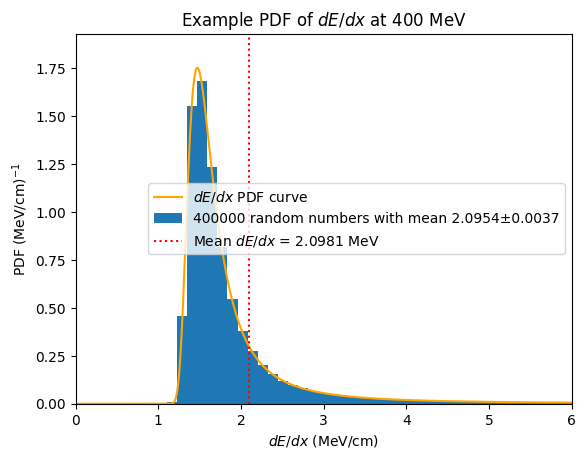

### Vavilov
Mean from integration:			5.8783893853451135 MeV
Mean from dEdx_mean:			5.8780424594591 MeV
Mean of generated raondom numbers:	5.879844661342543 ± 0.0016801577962584765 MeV


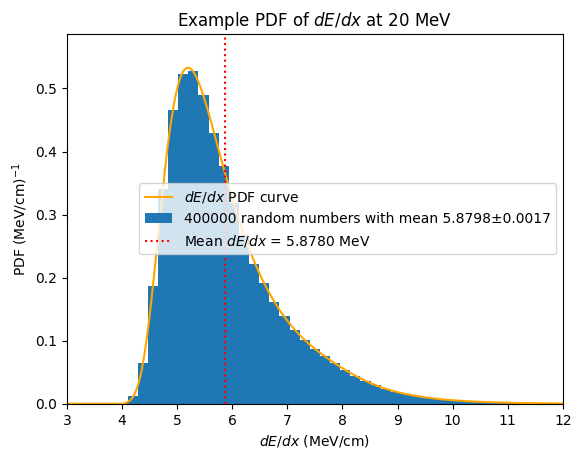

### Gaussian
Mean from integration:			34.44066884802913 MeV
Mean from dEdx_mean:			34.44066999663276 MeV
Mean of generated raondom numbers:	34.441702587519664 ± 0.0015750664710206283 MeV


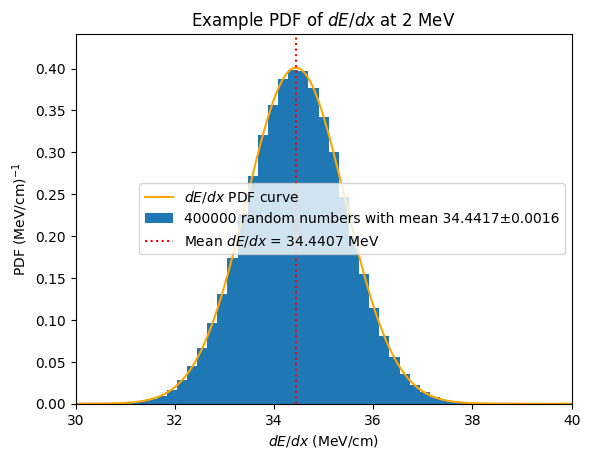

In [16]:
print("### Landau")
test_KE = test_KE_1
dEdx_rdm_arr = dEdx_rdm_arr_1
xrange = [0, 6]
dEdx_pdf_arr = []
xx = np.linspace(*xrange,1000)
for ixx in xx:
    dEdx_pdf_arr.append(dEdx_pdf(ixx, test_KE, test_pitch))
plt.plot(xx, dEdx_pdf_arr, "orange", label=r"$dE/dx$ PDF curve")
cutoff = dEdx_cutoff(test_KE, test_pitch)
integral = integrate.quad(lambda x: dEdx_pdf(x, test_KE, test_pitch), 0, cutoff)
print(f"Mean from integration:\t\t\t{integrate.quad(lambda x: x*dEdx_pdf(x, test_KE, test_pitch)/integral[0], 0, cutoff)[0]} MeV")
print(f"Mean from dEdx_mean:\t\t\t{dEdx_mean(test_KE)} MeV")
ylim = [0,1.1*np.max(dEdx_pdf_arr)]
print(f"Mean of generated raondom numbers:\t{np.mean(dEdx_rdm_arr)} ± {stats.sem(dEdx_rdm_arr)} MeV")
plt.hist(dEdx_rdm_arr, bins=np.linspace(*xrange,50), density=True, label=f"{Nrdm} random numbers with mean {np.mean(dEdx_rdm_arr):.4f}±{stats.sem(dEdx_rdm_arr):.4f}")
plt.plot([dEdx_mean(test_KE)]*2, ylim, "r:", label=rf"Mean $dE/dx$ = {dEdx_mean(test_KE):.4f} MeV")
plt.xlim(xrange)
plt.ylim(ylim)
plt.xlabel(r"$dE/dx$ (MeV/cm)")
plt.ylabel(r"PDF (MeV/cm)$^{-1}$")
plt.title(rf"Example PDF of $dE/dx$ at {test_KE} MeV")
plt.legend()
plt.show()

print("### Vavilov")
test_KE = test_KE_2
dEdx_rdm_arr = dEdx_rdm_arr_2
xrange = [3, 12]
dEdx_pdf_arr = []
xx = np.linspace(*xrange,1000)
for ixx in xx:
    dEdx_pdf_arr.append(dEdx_pdf(ixx, test_KE, test_pitch))
plt.plot(xx, dEdx_pdf_arr, "orange", label=r"$dE/dx$ PDF curve")
cutoff = dEdx_cutoff(test_KE, test_pitch)
integral = integrate.quad(lambda x: dEdx_pdf(x, test_KE, test_pitch), 0, cutoff)
print(f"Mean from integration:\t\t\t{integrate.quad(lambda x: x*dEdx_pdf(x, test_KE, test_pitch)/integral[0], 0, cutoff)[0]} MeV")
print(f"Mean from dEdx_mean:\t\t\t{dEdx_mean(test_KE)} MeV")
ylim = [0,1.1*np.max(dEdx_pdf_arr)]
print(f"Mean of generated raondom numbers:\t{np.mean(dEdx_rdm_arr)} ± {stats.sem(dEdx_rdm_arr)} MeV")
plt.hist(dEdx_rdm_arr, bins=np.linspace(*xrange,50), density=True, label=f"{Nrdm} random numbers with mean {np.mean(dEdx_rdm_arr):.4f}±{stats.sem(dEdx_rdm_arr):.4f}")
plt.plot([dEdx_mean(test_KE)]*2, ylim, "r:", label=rf"Mean $dE/dx$ = {dEdx_mean(test_KE):.4f} MeV")
plt.xlim(xrange)
plt.ylim(ylim)
plt.xlabel(r"$dE/dx$ (MeV/cm)")
plt.ylabel(r"PDF (MeV/cm)$^{-1}$")
plt.title(rf"Example PDF of $dE/dx$ at {test_KE} MeV")
plt.legend()
plt.show()

print("### Gaussian")
test_KE = test_KE_3
dEdx_rdm_arr = dEdx_rdm_arr_3
xrange = [30, 40]
dEdx_pdf_arr = []
xx = np.linspace(*xrange,1000)
for ixx in xx:
    dEdx_pdf_arr.append(dEdx_pdf(ixx, test_KE, test_pitch))
plt.plot(xx, dEdx_pdf_arr, "orange", label=r"$dE/dx$ PDF curve")
cutoff = dEdx_cutoff(test_KE, test_pitch)
integral = integrate.quad(lambda x: dEdx_pdf(x, test_KE, test_pitch), 0, cutoff)
print(f"Mean from integration:\t\t\t{integrate.quad(lambda x: x*dEdx_pdf(x, test_KE, test_pitch)/integral[0], 0, cutoff)[0]} MeV")
print(f"Mean from dEdx_mean:\t\t\t{dEdx_mean(test_KE)} MeV")
ylim = [0,1.1*np.max(dEdx_pdf_arr)]
print(f"Mean of generated raondom numbers:\t{np.mean(dEdx_rdm_arr)} ± {stats.sem(dEdx_rdm_arr)} MeV")
plt.hist(dEdx_rdm_arr, bins=np.linspace(*xrange,50), density=True, label=f"{Nrdm} random numbers with mean {np.mean(dEdx_rdm_arr):.4f}±{stats.sem(dEdx_rdm_arr):.4f}")
plt.plot([dEdx_mean(test_KE)]*2, ylim, "r:", label=rf"Mean $dE/dx$ = {dEdx_mean(test_KE):.4f} MeV")
plt.xlim(xrange)
plt.ylim(ylim)
plt.xlabel(r"$dE/dx$ (MeV/cm)")
plt.ylabel(r"PDF (MeV/cm)$^{-1}$")
plt.title(rf"Example PDF of $dE/dx$ at {test_KE} MeV")
plt.legend()
plt.show()

In [3]:
def gen_ardmv_from_pdf(pdf, xmin, xmax, ymax, **kwargs):
    ardmv = 0
    while ardmv == 0:
        size = 30
        xx = np.random.uniform(xmin, xmax, size)
        yy = np.array([pdf(ixx, **kwargs) for ixx in xx])
        score = np.random.uniform(0, ymax, size)
        judgmap = score<yy
        rdmv = xx[judgmap]
        if len(rdmv) > 0:
            ardmv = rdmv[0]
            return ardmv
def dEdx_rdm(KE, pitch=0.1):
    return gen_ardmv_from_pdf(dEdx_pdf, 0, dEdx_cutoff(KE,pitch), 1.2*np.maximum(dEdx_mean(KE), dEdx_MPV(KE,pitch)), KE=KE, pitch=pitch)
#def dEdx_pdf(x, KE, pitch):
#    return stats.norm.pdf(x, dEdx_mean(KE), pitch)
#def dEdx_rdm(KE, pitch=0.1):
#    loc = dEdx_mean(KE)
#    scale = pitch
#    return gen_ardmv_from_pdf(dEdx_pdf, 0, 2*loc, stats.norm.pdf(loc,loc,scale), KE=KE, pitch=pitch)


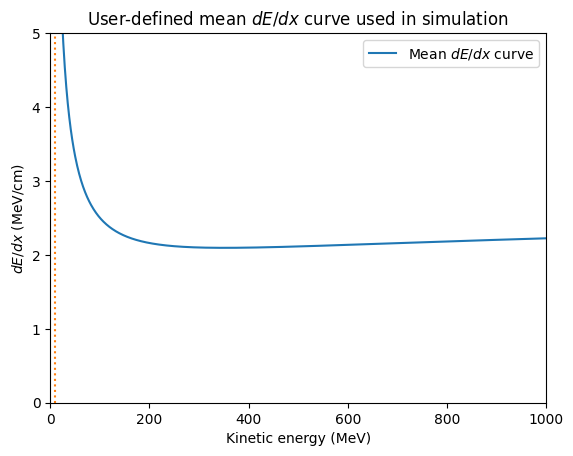

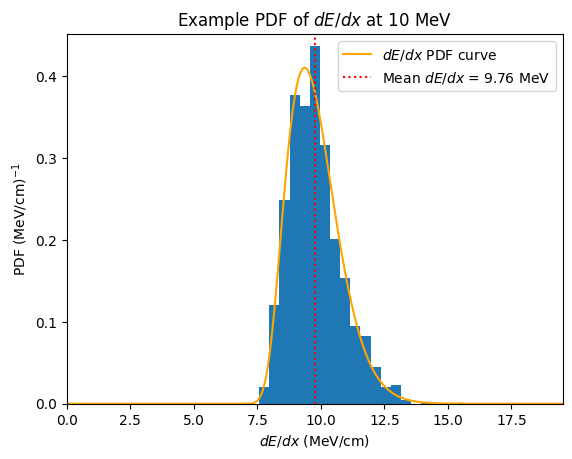

In [60]:
### dE/dx as a function of KE described by Bethe-Bloch formula

### plot the simulated dE/dx curve
xx = np.arange(0.5,1000.5,1)
plt.plot(xx, [dEdx_mean(ixx) for ixx in xx], "-", label=r"Mean $dE/dx$ curve")
plt.xlim([0,1000])
ylim = [0,5]
plt.ylim(ylim)
plt.xlabel("Kinetic energy (MeV)")
plt.ylabel(r"$dE/dx$ (MeV/cm)")
plt.title(r"User-defined mean $dE/dx$ curve used in simulation")
test_KE = 10
plt.plot([test_KE]*2, ylim, ":")
plt.legend()
#plt.savefig("figs/mean_dEdx.pdf")
plt.show()

### dE/dx distribution with the mean value provided

### plot the dE/dx curve with a certain mean value (TB added)
xx = np.linspace(0,2*dEdx_mean(test_KE),1000)
test_pitch = 0.1
dEdx_landau = []
for ixx in xx:
    dEdx_landau.append(dEdx_pdf(ixx, test_KE, test_pitch))
plt.plot(xx, dEdx_landau, "orange", label=r"$dE/dx$ PDF curve")
ylim = [0,1.1*np.max(dEdx_landau)]
#ttmp = gen_ardmv_from_pdf(dEdx_pdf, 0, cutoff, KE=test_KE, pitch=test_pitch)
ttmp = [dEdx_rdm(test_KE) for i in range(1000)]
plt.hist(ttmp, bins=np.linspace(0,2*dEdx_mean(test_KE),50), density=True)
plt.plot([dEdx_mean(test_KE)]*2, ylim, "r:", label=rf"Mean $dE/dx$ = {dEdx_mean(test_KE):.2f} MeV")
plt.xlim([0,2*dEdx_mean(test_KE)])
plt.ylim(ylim)
plt.xlabel(r"$dE/dx$ (MeV/cm)")
plt.ylabel(r"PDF (MeV/cm)$^{-1}$")
plt.title(rf"Example PDF of $dE/dx$ at {test_KE} MeV")
plt.legend()
#plt.savefig("figs/dEdx_PDF.pdf")
plt.show()

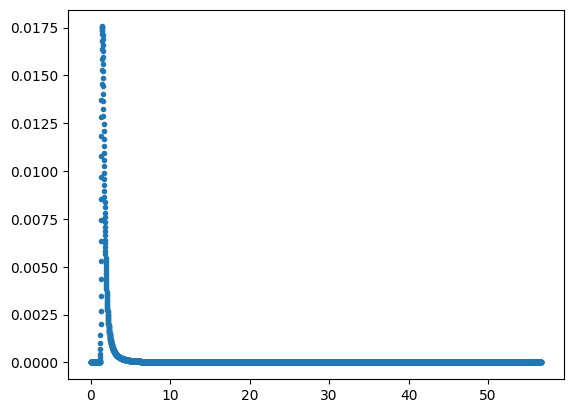

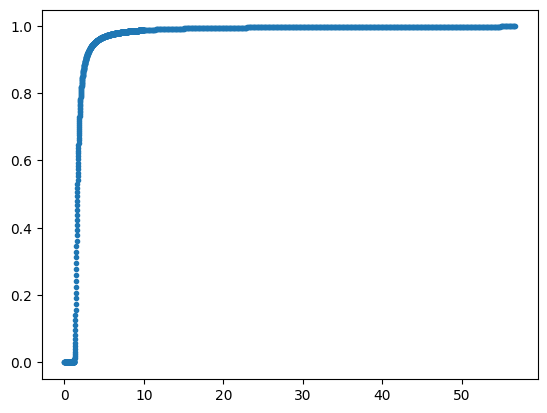

In [10]:
test_KE = 400
test_pitch = 0.1
xx = np.arange(0, dEdx_cutoff(test_KE,test_pitch)+1e-5, 0.01)
yy = [dEdx_pdf(ixx, test_KE,test_pitch) for ixx in xx]
yy = np.array(yy)/np.sum(yy)
plt.plot(xx, yy, ".")
plt.show()
def calculate_cdf(x0, test_KE, test_pitch):
    # Use quad to integrate the PDF from -infinity to x
    cdf, _ = integrate.quad(lambda x: dEdx_pdf(x, test_KE, test_pitch), 0, x0)
    return cdf
xx = np.concatenate([np.arange(0, 10, 0.01), np.arange(10, dEdx_cutoff(test_KE,test_pitch)+1e-5, 0.1)])
cdf_value = [calculate_cdf(ixx, test_KE,test_pitch) for ixx in xx]
plt.plot(xx, cdf_value, ".")
plt.show()

In [7]:
ttmp = time()
calculate_cdf(1, test_KE,test_pitch)
print("Time:", time()-ttmp)

ttmp = time()
calculate_cdf(5, test_KE,test_pitch)
print("Time:", time()-ttmp)

ttmp = time()
calculate_cdf(20, test_KE,test_pitch)
print("Time:", time()-ttmp)

ttmp = time()
calculate_cdf(50, test_KE,test_pitch)
print("Time:", time()-ttmp)


Time: 0.04007601737976074
Time: 0.09800505638122559
Time: 0.11891984939575195
Time: 0.13427519798278809


In [75]:
test_KE = 400

ttmp = time()
np.random.chisquare(dEdx_BB(test_KE))
print("chi2 Time:", time()-ttmp)

ttmp = time()
stats.chi2.rvs(dEdx_BB(test_KE))
print("chi2 Time:", time()-ttmp)

ttmp = time()
dEdx_rdm(test_KE, pitch=0.1)
print("dEdx Time:", time()-ttmp)

ttmp = time()
stats.chi2.pdf(2.1, 2.1)
print("chi2 pdf Time:", time()-ttmp)

ttmp = time()
dEdx_pdf(2.1, 400, 0.1)
print("dEdx pdf Time:", time()-ttmp)

chi2 Time: 5.7220458984375e-05
chi2 Time: 9.584426879882812e-05
dEdx Time: 0.0005090236663818359
chi2 pdf Time: 0.0001380443572998047
dEdx pdf Time: 0.0003781318664550781


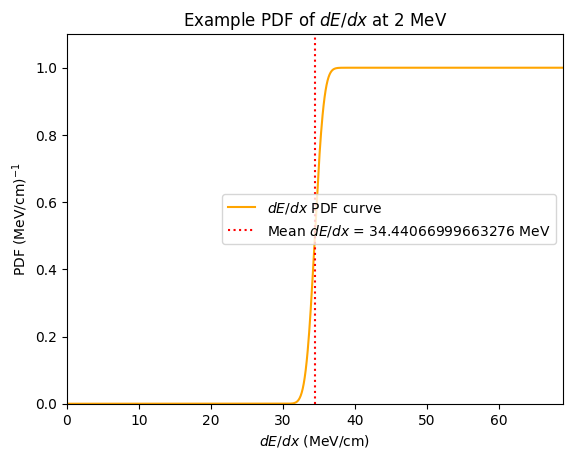

In [70]:
dEdx_landau = []
test_KE = 2
test_pitch = 0.1
xx = np.linspace(0,2*dEdx_mean(test_KE),1000)
for ixx in xx:
    dEdx_landau.append(dEdx_cdf(ixx, test_KE, test_pitch))
plt.plot(xx, dEdx_landau, "orange", label=r"$dE/dx$ PDF curve")
cutoff = dEdx_cutoff(test_KE, test_pitch)
#integral = integrate.quad(lambda x: dEdx_pdf(x, test_KE, test_pitch), 0, cutoff)
#print("Cutoff: ", cutoff)
#print("Integral: ", integral[0])
#print("MPV: ", dEdx_MPV(test_KE, test_pitch))
#print("Mean: ", integrate.quad(lambda x: x*dEdx_pdf(x, test_KE, test_pitch)/integral[0], 0, cutoff)[0])
ylim = [0,1.1*np.max(dEdx_landau)]
#ttmp = gen_ardmv_from_pdf(dEdx_pdf, 0, cutoff, KE=test_KE, pitch=test_pitch)
#plt.hist(ttmp, bins=np.linspace(0,2*dEdx_mean(test_KE),50), density=True)
plt.plot([dEdx_mean(test_KE)]*2, ylim, "r:", label=rf"Mean $dE/dx$ = {dEdx_mean(test_KE)} MeV")
plt.xlim([0,2*dEdx_mean(test_KE)])
plt.ylim(ylim)
plt.xlabel(r"$dE/dx$ (MeV/cm)")
plt.ylabel(r"PDF (MeV/cm)$^{-1}$")
plt.title(rf"Example PDF of $dE/dx$ at {test_KE} MeV")
plt.legend()
#plt.savefig("figs/dEdx_PDF.pdf")
plt.show()
#print(Get_Wmax(1000),Get_Wmax(500),Get_Wmax(100),Get_Wmax(50))
#print(dEdx_mean(100),dEdx_mean(80),dEdx_mean(1))
#print(dEdx_pdf(2.1, 100, 0.1), dEdx_pdf(2.1, 80, 0.1), dEdx_pdf(2.1, 1, 0.1))